## 超解像_SRCNN

In [1]:
import os
import glob
import math
import random
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model,Sequential
from tensorflow.python.keras.layers import Conv2D,Dense,Input,MaxPooling2D, UpSampling2D,Lambda
from tensorflow.python.keras.preprocessing.image import load_img,img_to_array,array_to_img,ImageDataGenerator

### drop resolution of image

In [2]:
def drop_resolution(x,scale=3.0):
    size = (x.shape[0],x.shape[1])
    small_size = (int(size[0]/scale), int(size[1]/scale))
    img = array_to_img(x)
    small_img = img.resize(small_size,3)
    return img_to_array(small_img.resize(img.size,3))

### get data and create data for low resolution and high resolution

In [3]:
from scipy import ndimage
import scipy
def data_generator(data_dir,mode,scale=2.0,target_size=(200,200),batch_size=32,shuffle = True):
    for imgs in ImageDataGenerator().flow_from_directory(
        directory = data_dir,
        classes = [mode],
        class_mode = None,
        color_mode = 'rgb',
        target_size = target_size,
        batch_size = batch_size,
        shuffle = shuffle
    ):
        x = np.array([drop_resolution(img,scale) for img in imgs])
        yield x/255.,imgs/255.

### get data from folder

In [12]:

DATA_DIR = 'img_c10'
N_TRAIN_DATA = 1000
N_TEST_DATA = 100
BATCH_SIZE = 20
train_data_generator = data_generator(DATA_DIR, 'train', batch_size = BATCH_SIZE)

In [13]:
test_x,test_y = next(data_generator(
        DATA_DIR,
        'test',
        batch_size = N_TEST_DATA,
        shuffle = False
    ))

Found 100 images belonging to 1 classes.


### create model

In [14]:
model = Sequential()
model.add(Conv2D(
    filters = 64,
    kernel_size = 9,
    padding = 'same',
    activation = 'relu',
    input_shape = (None,None,3)
))
model.add(Conv2D(
    filters = 32,
    kernel_size = 1,
    padding = 'same',
    activation = 'relu'
))
model.add(Conv2D(
    filters = 3,
    kernel_size = 5,
    padding = 'same'
))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, None, None, 64)    15616     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 3)     2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


### PSNR(peak signal-to-noise ratio) calculation

In [15]:
def psnr(y_true,y_pred):
    return -10*K.log(
        K.mean(K.flatten((y_true - y_pred))**2)
    )/np.log(10)

### compile model and train

In [16]:
model.compile(
    loss = 'mean_squared_error',
    optimizer = 'adam',
    metrics = [psnr]
)

In [17]:
model.fit_generator(
    train_data_generator,
    validation_data = (test_x,test_y),
    steps_per_epoch = N_TRAIN_DATA//BATCH_SIZE,
    epochs = 50
)

Epoch 1/50
Found 1000 images belonging to 1 classes.
50/50 [==============================] - 15s 306ms/step - loss: 0.0295 - psnr: 17.1828 - val_loss: 0.0117 - val_psnr: 19.3527
Epoch 2/50
50/50 [==============================] - 13s 258ms/step - loss: 0.0086 - psnr: 20.7661 - val_loss: 0.0075 - val_psnr: 21.2983
Epoch 3/50
50/50 [==============================] - 13s 258ms/step - loss: 0.0062 - psnr: 22.1287 - val_loss: 0.0065 - val_psnr: 21.9190
Epoch 4/50
50/50 [==============================] - 13s 258ms/step - loss: 0.0060 - psnr: 22.2943 - val_loss: 0.0057 - val_psnr: 22.4951
Epoch 5/50
50/50 [==============================] - 13s 259ms/step - loss: 0.0053 - psnr: 22.8468 - val_loss: 0.0061 - val_psnr: 22.2053
Epoch 6/50
50/50 [==============================] - 13s 258ms/step - loss: 0.0052 - psnr: 22.9308 - val_loss: 0.0053 - val_psnr: 22.8280
Epoch 7/50
50/50 [==============================] - 13s 258ms/step - loss: 0.0047 - psnr: 23.3933 - val_loss: 0.0050 - val_psnr: 23.1147

In [18]:
pred = model.predict(test_x)

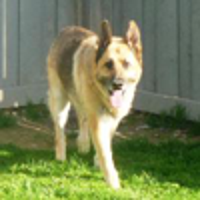

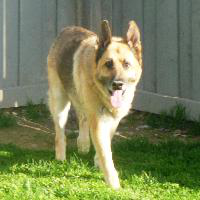

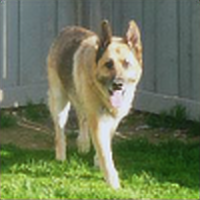

-------------------------


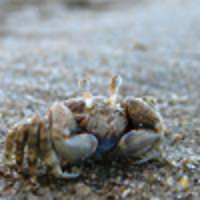

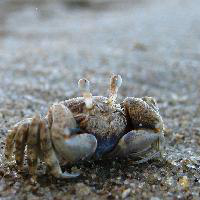

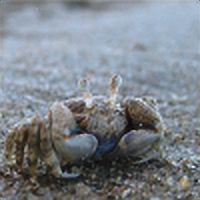

-------------------------


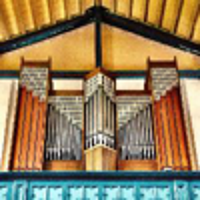

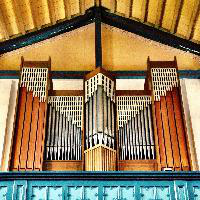

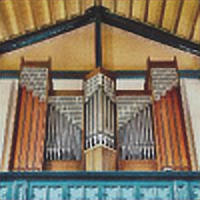

-------------------------


In [19]:
from IPython.display import display_png
for i in range(test_x.shape[0]):
    display_png(array_to_img(test_x[i]))
    display_png(array_to_img(test_y[i]))
    display_png(array_to_img(pred[i]))
    print('-'*25)
    if i == 2:
        break